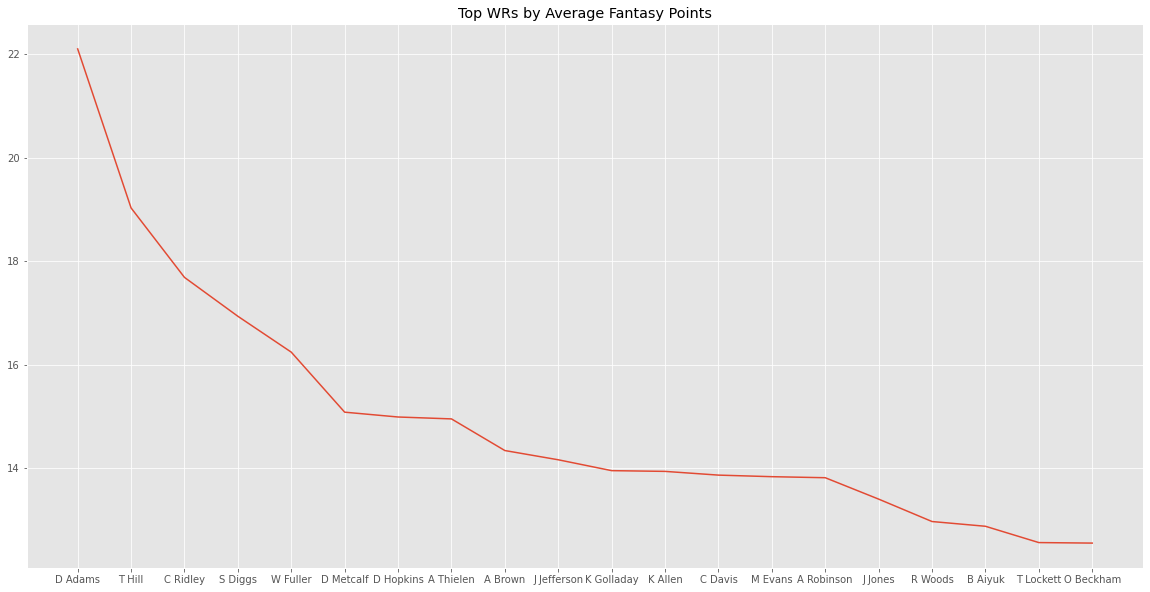

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1, 12)]      0           []                               
                                                                                                  
 lstm_24 (LSTM)                 (None, 1, 12)        1200        ['input_9[0][0]']                
                                                                                                  
 lstm_25 (LSTM)                 (None, 1, 24)        3552        ['lstm_24[0][0]']                
                                                                                                  
 lstm_26 (LSTM)                 [(None, 25),         5000        ['lstm_25[0][0]']                
                                 (None, 25),                                                

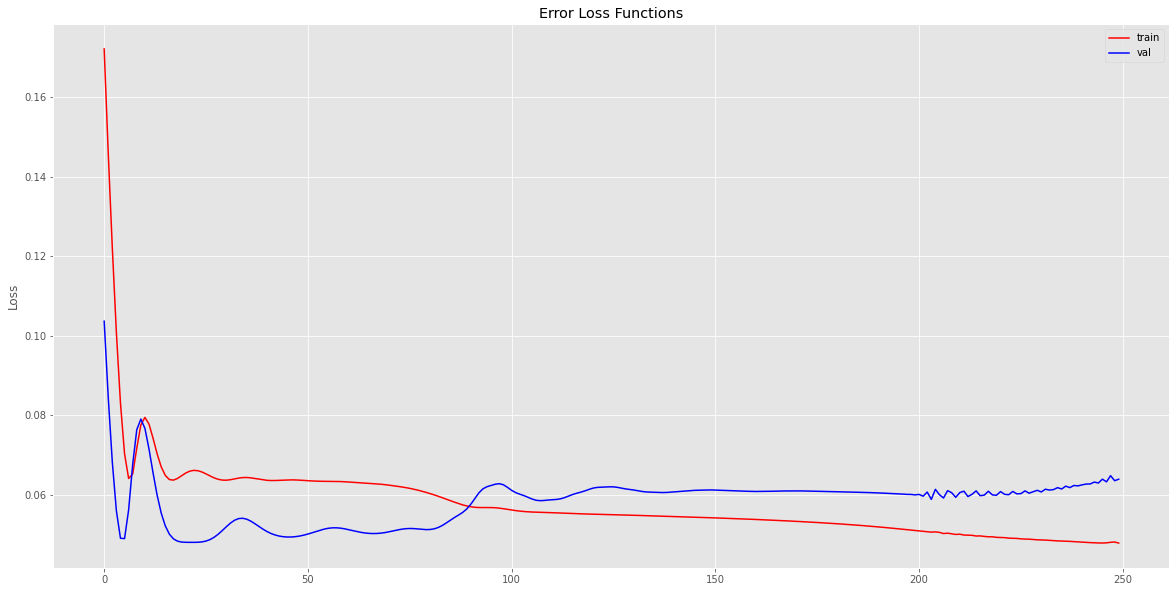

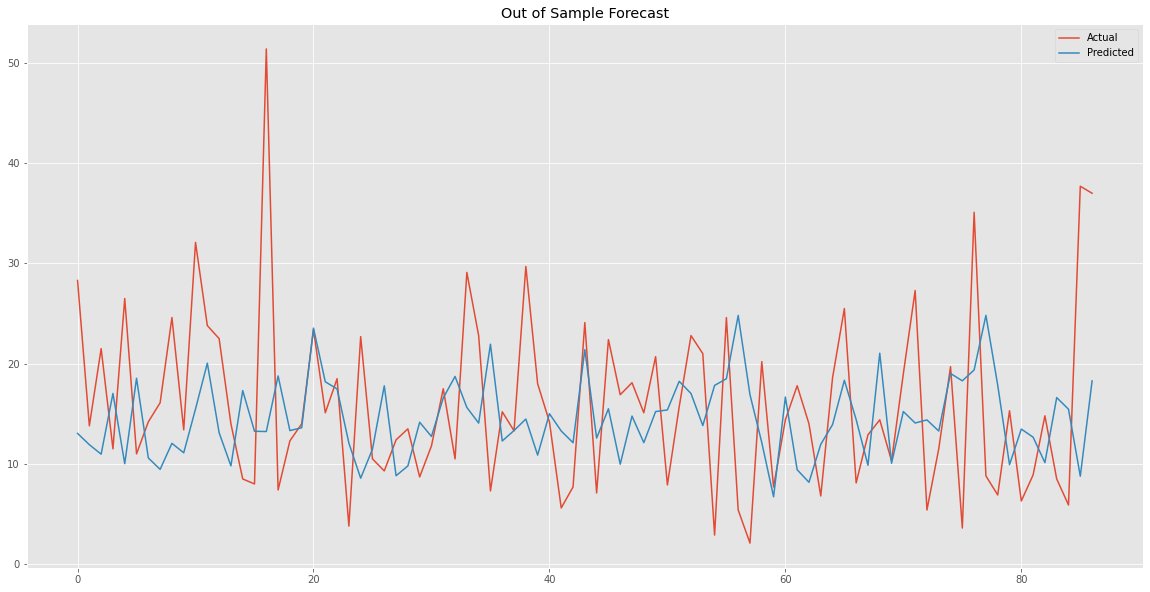

In [14]:
# import packages
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as py
from matplotlib.pylab import rcParams
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.layers.merge import concatenate
py.style.use('ggplot')

# import the full database csv
df = pd.read_csv('full_database.csv')

# create a WR dataframe
wr_df = df[df.Pos == 'WR']

# extract unique wr values
unique_wr = []
for x in list(wr_df.Name):
    if x not in unique_wr:
        unique_wr.append(x)

# calculate wr fantasy point averages
wr_averages = pd.DataFrame(columns = ['Name', 'Average'], index = range(len(unique_wr)))
for i in range(len(unique_wr)):
    temp_wr = df[df.Name == unique_wr[i]]
    ffp = temp_wr.FD_points.sum()/len(temp_wr)
    wr_averages.Average[i] = (ffp)
    wr_averages.Name[i] = unique_wr[i]

# sort by highest average
wr_2020 = wr_averages.sort_values('Average', ascending = False)

# pull the names of the wr's with the top 20 highest averages
wrNames = []
for x in wr_2020.Name.head(20):
    wrNames.append(x.split()[:-1])
abbvName = [(list(x[0])[0] + ' ' + x[1]) for x in wrNames]
py.plot(abbvName,wr_2020.Average.head(20))
py.title('Top WRs by Average Fantasy Points')
py.show()

# set the main df to the bestWrs csv file
df = pd.read_csv('bestWrs.csv')

# drop rows with missing values, drop unused columns, sort by date and reset index
df.drop(columns=['Unnamed: 0'], inplace=True)
df.dropna(inplace=True)
df.Date = pd.to_datetime(df.Date)
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# model output (y) and inputs (x)
y = df.iloc[:,4]
x = df.iloc[:,16:]

###########################################################################################

# preprocessing function
# train data size is 40 percent val is 15 and test is 55 (need more data in future, test size should be smaller here if possible)
def df_test_train(x,y):

    train_x = x.loc[:int(.40*len(x))]
    train_y = y.loc[:int(.40*len(x))]
    val_x = x.loc[int(.40*len(y)):int(.55*len(x))]
    val_y = y.loc[int(.40*len(y)):int(.55*len(y))]
    test_x = x.loc[int(.55*len(x)):]
    test_y = y.loc[int(.55*len(x)):]
    
    scaler = MinMaxScaler()
    scaler2 = MinMaxScaler()
    train_x = np.asarray(scaler.fit_transform(train_x))
    val_x = np.asarray(scaler.transform(val_x))
    test_x = np.asarray(scaler.transform(test_x))
    train_y = scaler2.fit_transform(np.asarray(train_y).reshape(-1,1))
    val_y = scaler2.transform(np.asarray(val_y).reshape(-1,1))
    test_y = scaler2.transform(np.asarray(test_y).reshape(-1,1))
   
    return train_x, train_y, val_x, val_y, test_x, test_y, scaler, scaler2


###########################################################################################

# EARLY STOP CONFIGURATION
earlystop = EarlyStopping(monitor='val_loss', min_delta=.0001, patience=8000,  verbose=1, mode='min')
callbacks_list = [earlystop]

# CREATE A CUSTOM ERROR LOSS FUNCTION
# flooding is a regularization technique for the error loss that reduces overfitting during model training
import tensorflow.keras.backend as kb
def flood_loss(y_actual,y_pred):
    b=0.025
    loss=(kb.mean(kb.square(y_pred-y_actual-b))+b) # flooding concept using b term (floods out the bottom of the error loss)
    return loss

# BUILD AND TRAIN THE MODEL
def fit_model(train_data_x,train_data_y,val_data_x,val_data_y):
    timesteps = 1
    hl = [25,25]
    batch = 512
    epochs = 250
    flooding=True
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    
    # train data
    for i in range(timesteps,train_data_x.shape[0]):
        X_train.append(train_data_x[i-timesteps:i])
        Y_train.append(train_data_y[i][0])    
    X_train,Y_train = np.array(X_train),np.array(Y_train)
    
    # validation data
    for i in range(timesteps,val_data_x.shape[0]):
        X_val.append(val_data_x[i-timesteps:i])
        Y_val.append(val_data_y[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)   

    # neural net construction using keras API
    inputs = Input(shape = (X_train.shape[1],X_train.shape[2])) # input layer
    lstm = LSTM(X_train.shape[2], return_sequences=True)(inputs) # lstm layer
    lstm2 = LSTM(X_train.shape[2]*2, return_sequences=True)(lstm) # lstm layer               
    lstm1, state_h, state_c =  LSTM(25, return_state=True)(lstm2) # split layer into two and is the memory(h) and cell state(c)
    merge = concatenate([state_h, state_c]) # merge the split layers of the net to a single layer
    hidden1 = Dense(25)(merge) # dense hidden layer
    hidden2 = Dense(1000)(hidden1) # dense hidden layer
    output = Dense(1)(hidden2) # output
    model = Model(inputs = inputs, outputs = output) # map the model using keras API methodology
    print(model.summary())
    
    # set the error los in the model.compile based on the user provided 'flooding value'
    # note the adam optimized is for stochastic gradient descent
    if flooding == True:
        model.compile(loss=flood_loss, optimizer='adam', metrics=['accuracy'])
    else:
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    # history saves the trained fit of the model and the error loss function results
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    print(model.summary)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss'] # returns the moedl and the error losses

# EVALUATING THE MODEL
def evaluate_model(model,test_data_x,test_data_y,k):
    X_test = []
    Y_test = []

    # LOOP FOR TESTING DATA
    for i in range(k,test_data_x.shape[0]):
        X_test.append(test_data_x[i-k:i])
        Y_test.append(test_data_y[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)

    # PREDICTIONS
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)

    # PREDICTIONS TO DATAFRAME 
    test=pd.DataFrame()
    test=pd.DataFrame(columns=['Actual', 'Predicted'])
    test['Actual']=Y_test
    test['Predicted']=Y_hat
    table=test                   
    return mse, rmse, r, Y_test, Y_hat, table

# plot the loss functions
def plot_error(train_loss,val_loss):
    rcParams['figure.figsize'] = 20,10
    py.plot(train_loss,c = 'r')
    py.plot(val_loss,c = 'b')
    py.ylabel('Loss')
    py.legend(['train','val'],loc = 'upper right')
    py.title('Error Loss Functions')
    py.show()

# plot the model prediciton out of sample
def plot_pred(scaler,table):
  ffp = scaler.inverse_transform(np.asarray(table.Actual.values.reshape(-1,1)))
  ffp_pred = scaler.inverse_transform(np.asarray(table.Predicted.values.reshape(-1,1)))
  forecast = pd.DataFrame(columns = ['Actual', 'Predicted'], index = table.index)
  forecast.Actual = ffp
  forecast.Predicted = ffp_pred
  py.plot(forecast.Actual, label='Actual')
  py.plot(forecast.Predicted, label = 'Predicted')
  py.legend()
  py.title('Out of Sample Forecast')
  py.show()
  return forecast

# run the trained neural net model an an individual player history to generate out of sample projections for the individual player
def forecast(player_name,scaler,table, dfIndividual, individualTrain,k):
  ffp = scaler.inverse_transform(np.asarray(table.Actual.values.reshape(-1,1)))
  ffp_pred = scaler.inverse_transform(np.asarray(table.Predicted.values.reshape(-1,1)))
  forecast = pd.DataFrame(columns = ['Actual', 'Predicted'], index = table.index)
  forecast.Actual = ffp
  forecast.Predicted = ffp_pred
  py.plot(individualTrain.iloc[:,6], individualTrain.FD_points)
  py.plot(dfIndividual.iloc[k:,6],forecast.Actual, label='Actual')
  py.plot(dfIndividual.iloc[k:,6],forecast.Predicted, label = 'Predicted')
  py.title(player_name + ' FD Points')
  py.legend()
  py.show()
  return print(forecast)

# hyperparameters
k = 1
hl = [25,25]
batch = 512
epochs = 100
flooding=True

# train a new model
train_x, train_y, val_x, val_y, test_x, test_y, scaler, scaler2 = df_test_train(x,y)
model,train_error,val_error = fit_model(train_x,train_y,val_x,val_y)
mse, rmse, r2_value,true,predicted,table = evaluate_model(model,test_x,test_y,k)

# view the error loss functions and model out of sample forecast
plot_error(train_error,val_error)
plot_pred(scaler2,table)

#model.save('qb_model.h5')
#model.save('rb_model.h5')
model.save('wr_model.h5') # the model can be loaded and reused on the below forecasts



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


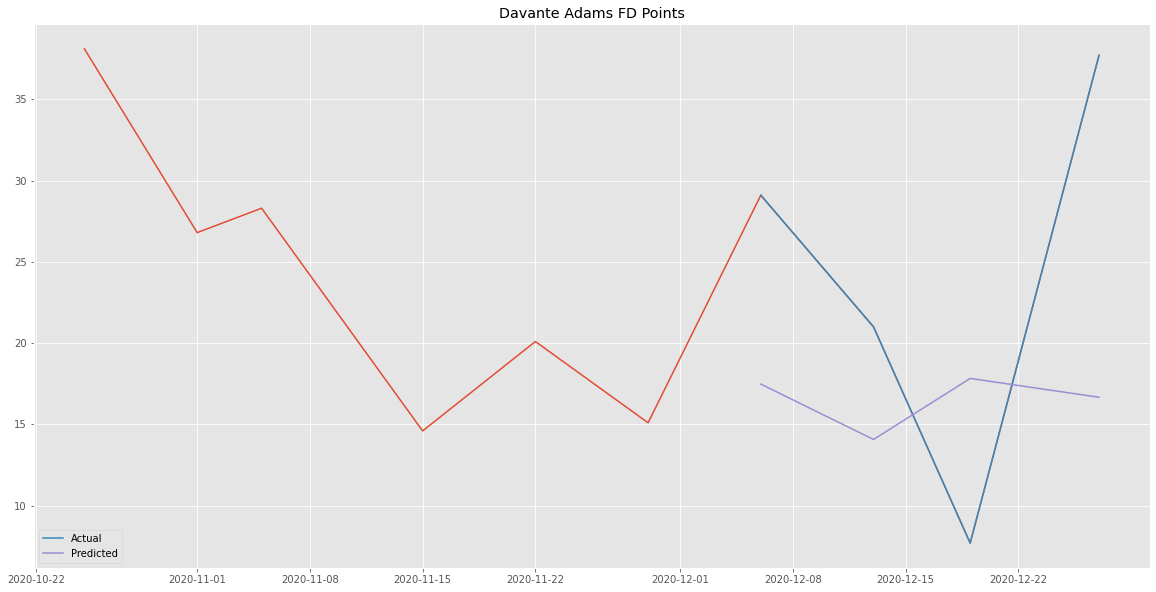

   Actual  Predicted
0    29.1  17.480833
1    21.0  14.073519
2     7.7  17.829473
3    37.7  16.671532


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


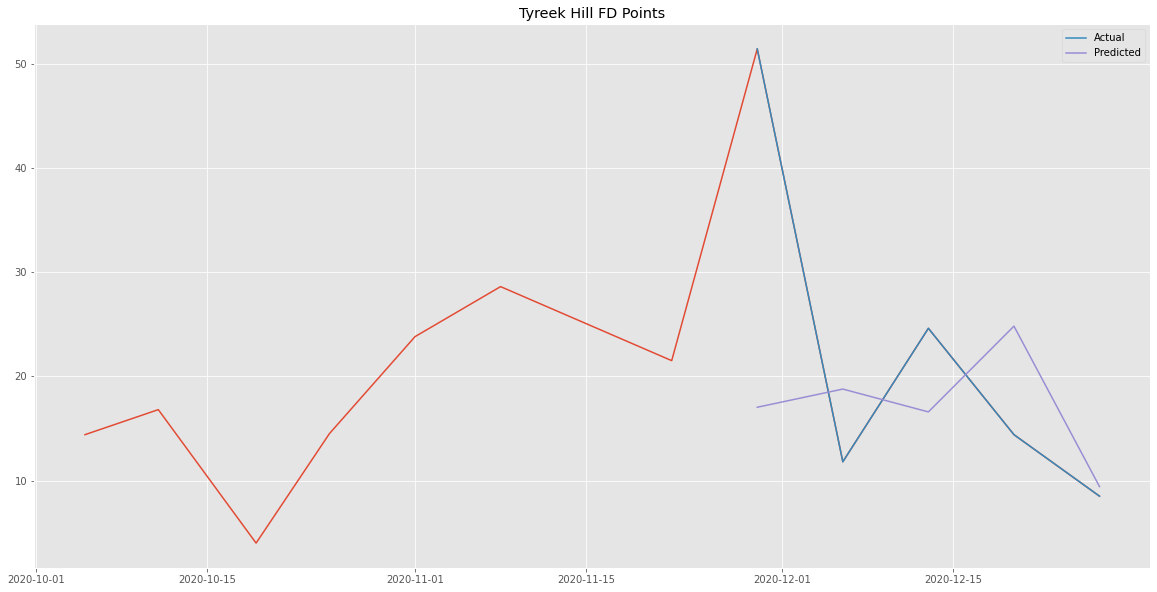

   Actual  Predicted
0    51.4  17.029362
1    11.8  18.773016
2    24.6  16.582384
3    14.4  24.809877
4     8.5   9.417765


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


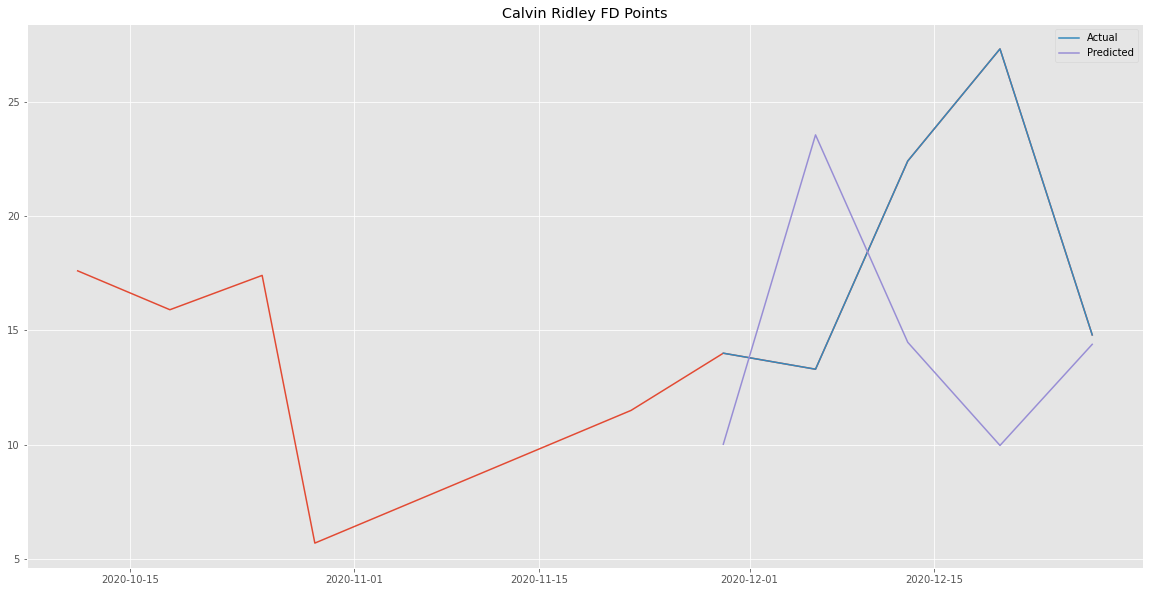

   Actual  Predicted
0    14.0  10.020740
1    13.3  23.542555
2    22.4  14.476584
3    27.3   9.968155
4    14.8  14.387873


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


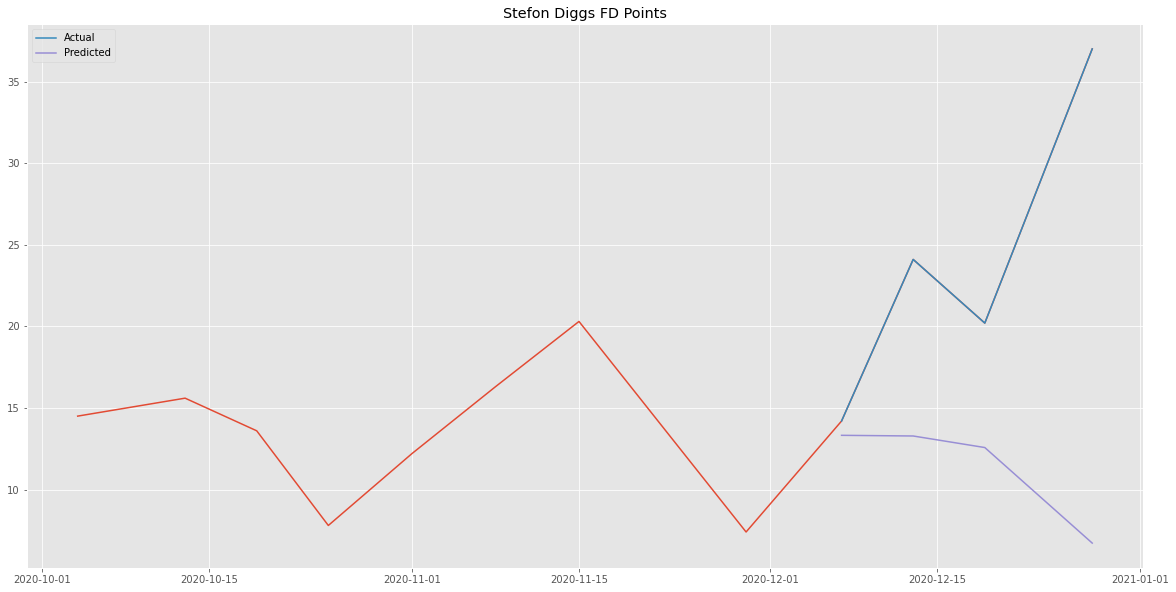

   Actual  Predicted
0    14.2  13.323494
1    24.1  13.282183
2    20.2  12.574548
3    37.0   6.719953


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


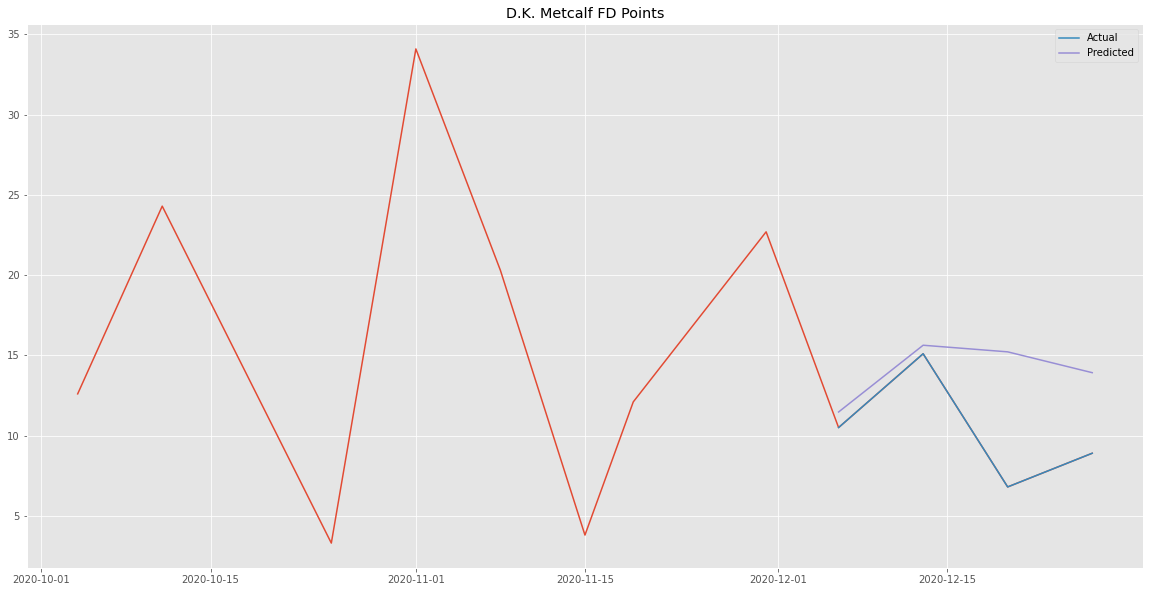

   Actual  Predicted
0    10.5  11.470800
1    15.1  15.631483
2     6.8  15.219235
3     8.9  13.920948


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


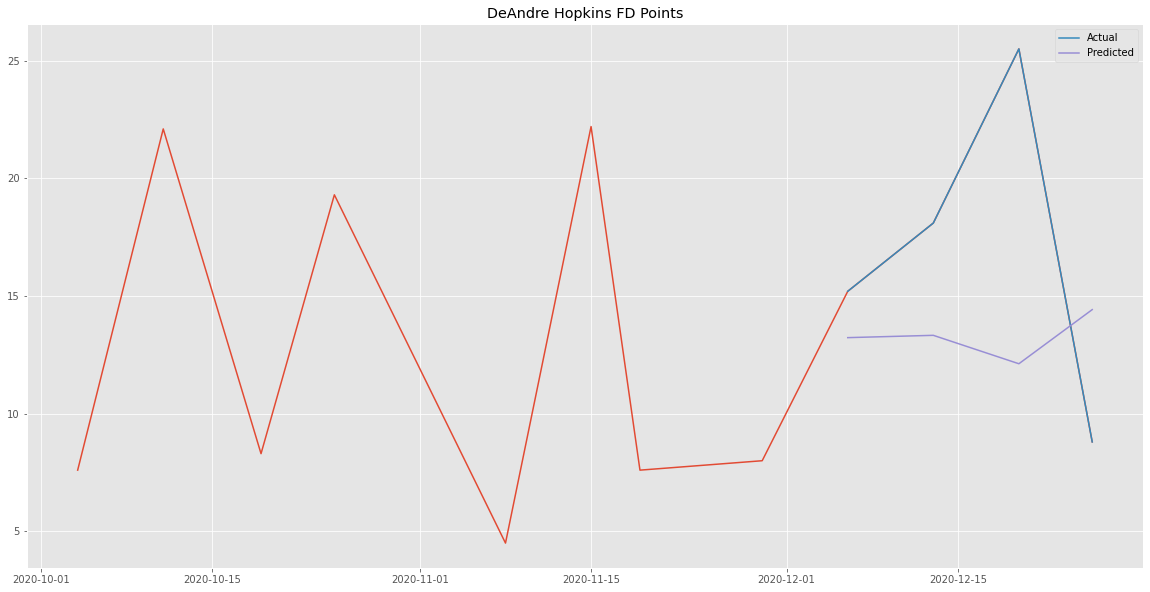

   Actual  Predicted
0    15.2  13.230536
1    18.1  13.328943
2    25.5  12.121119
3     8.8  14.421444


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


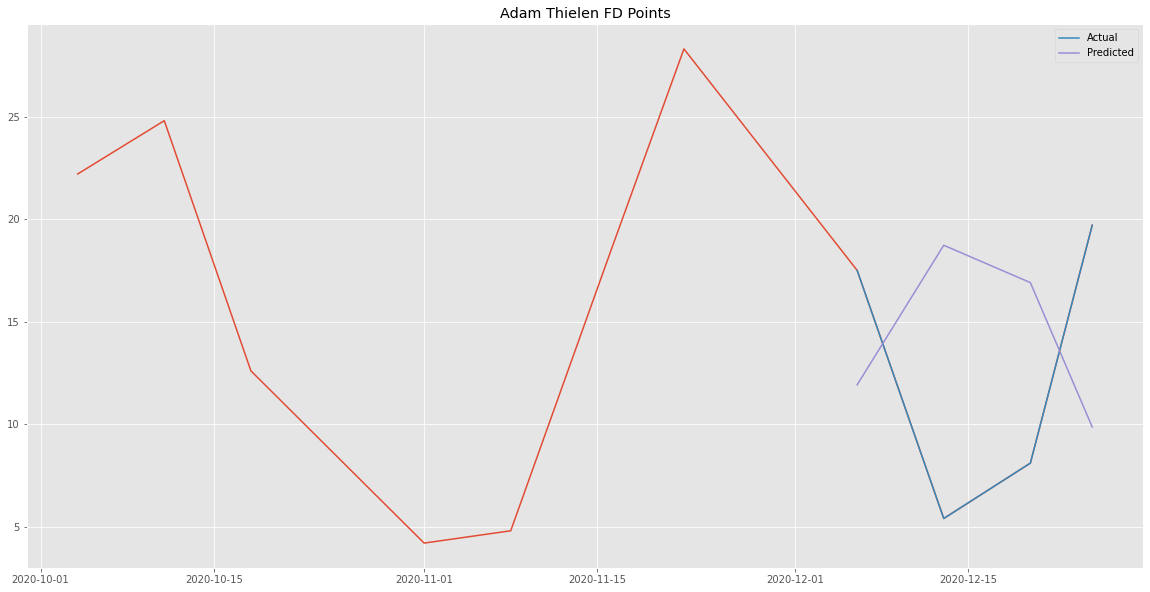

   Actual  Predicted
0    17.5  11.918393
1     5.4  18.725170
2     8.1  16.902275
3    19.7   9.863398


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


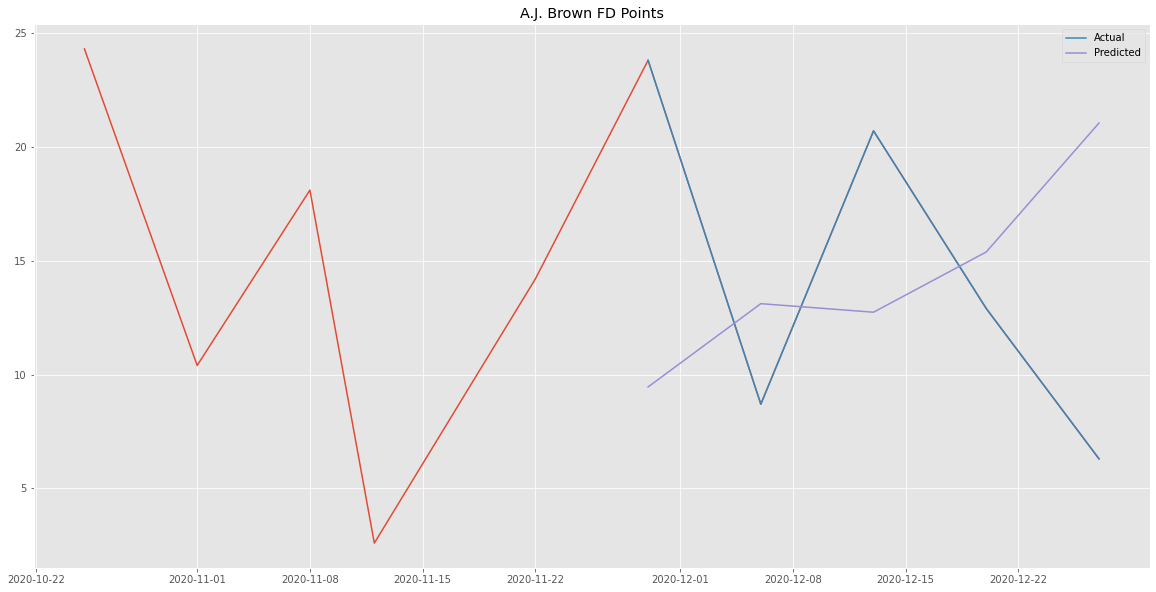

   Actual  Predicted
0    23.8   9.456309
1     8.7  13.113457
2    20.7  12.738140
3    12.9  15.383741
4     6.3  21.045647


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


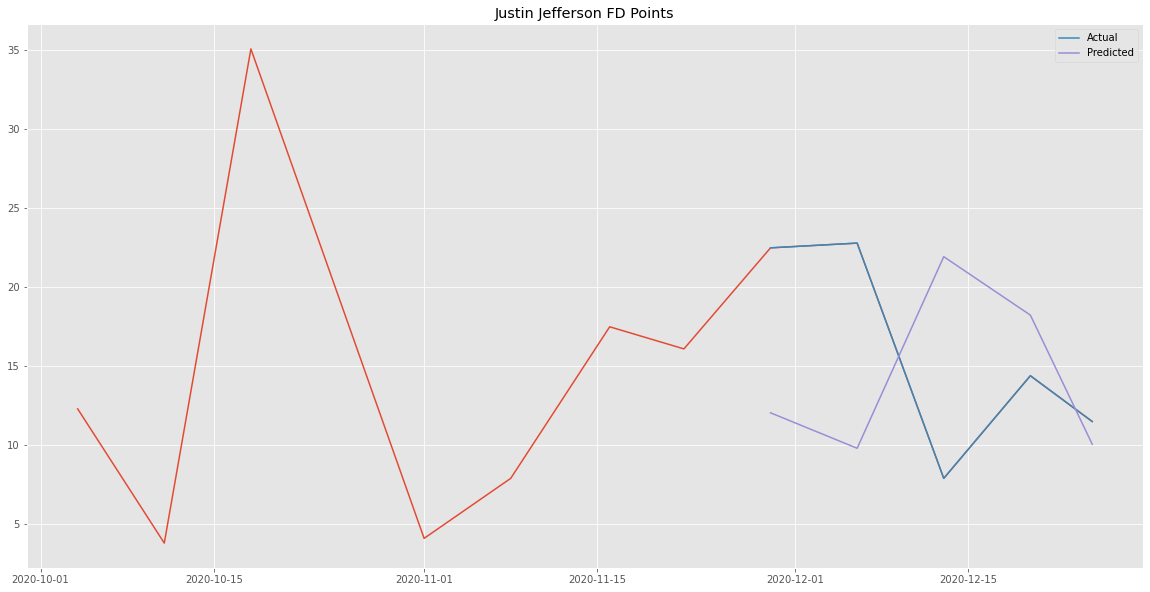

   Actual  Predicted
0    22.5  12.051943
1    22.8   9.805777
2     7.9  21.939997
3    14.4  18.239178
4    11.5  10.063628


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


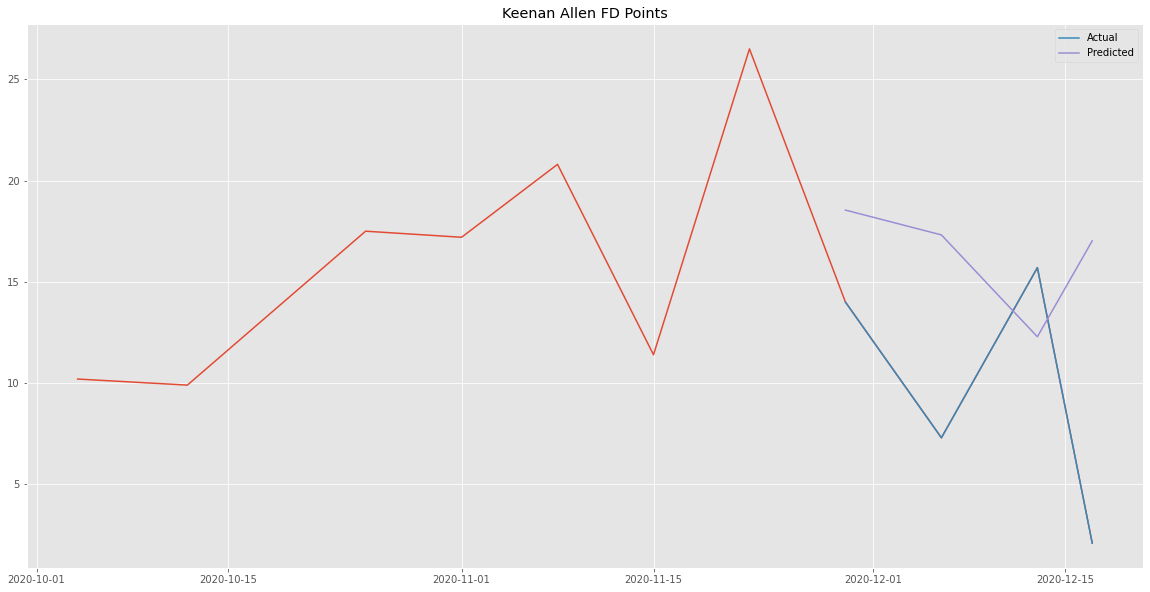

   Actual  Predicted
0    14.0  18.541935
1     7.3  17.316292
2    15.7  12.287549
3     2.1  17.024551


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


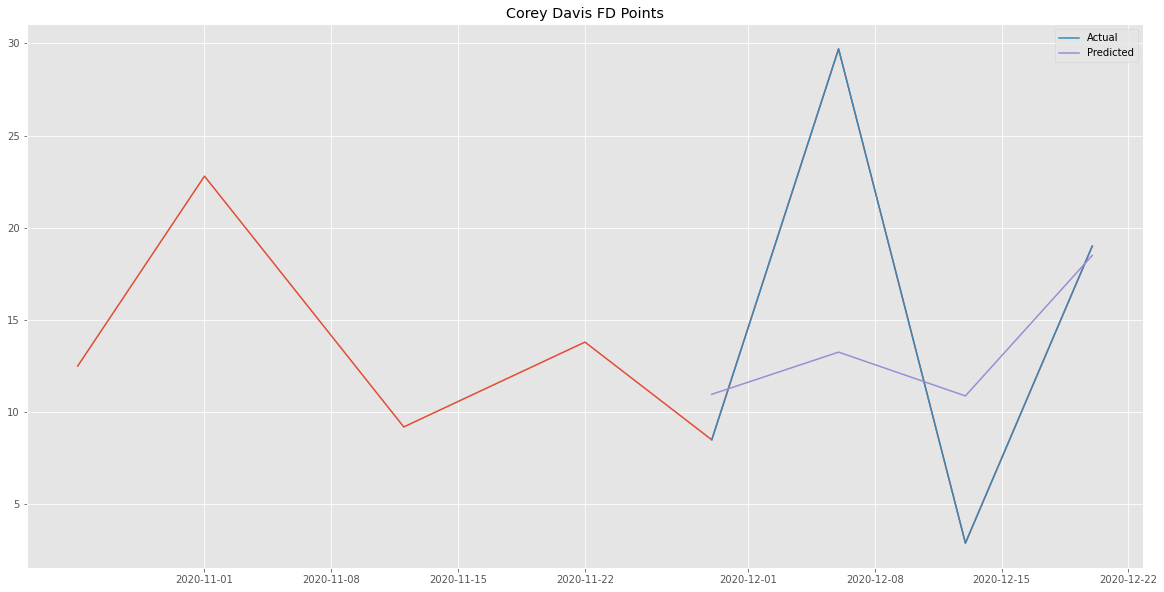

   Actual  Predicted
0     8.5  10.969646
1    29.7  13.255560
2     2.9  10.881446
3    19.0  18.498075


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


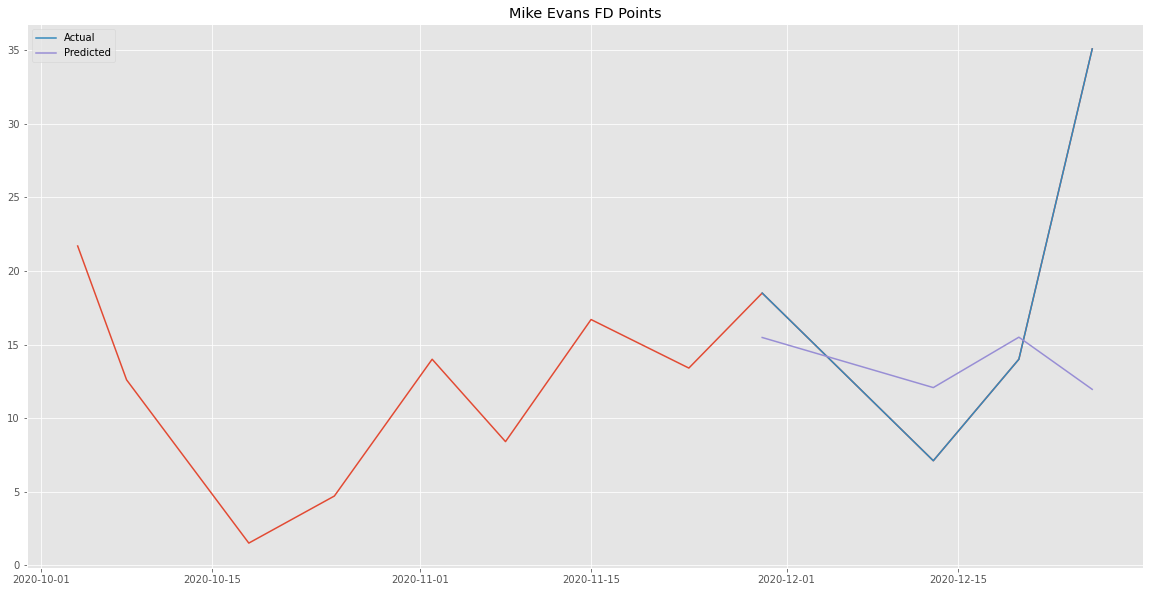

   Actual  Predicted
0    18.5  15.478880
1     7.1  12.073313
2    14.0  15.499780
3    35.1  11.953020


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


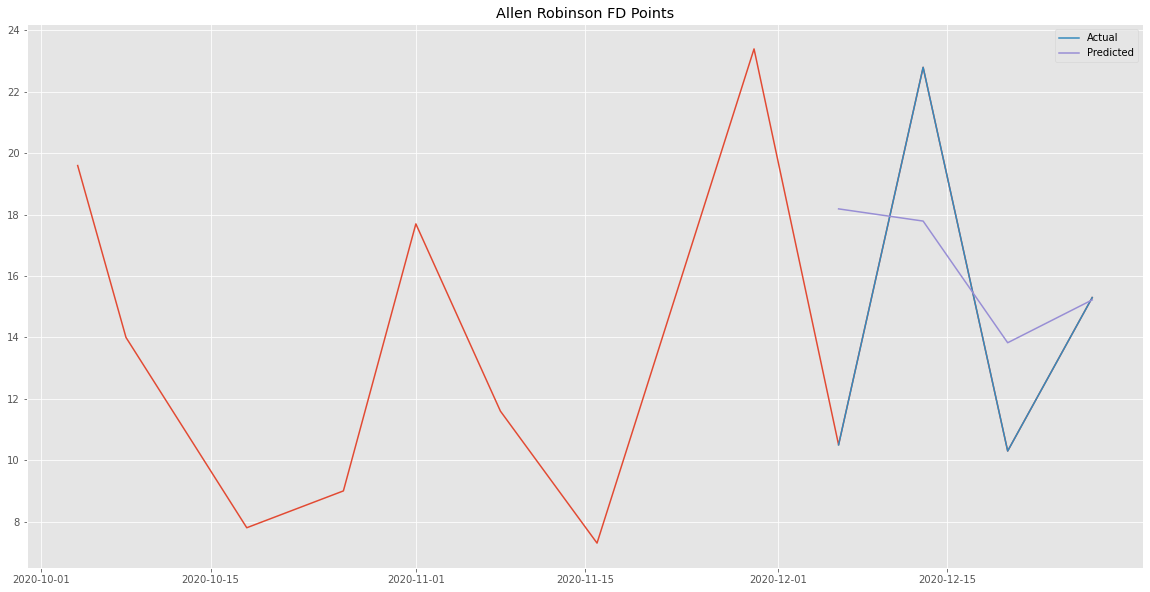

   Actual  Predicted
0    10.5  18.188334
1    22.8  17.790953
2    10.3  13.827086
3    15.3  15.223505


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


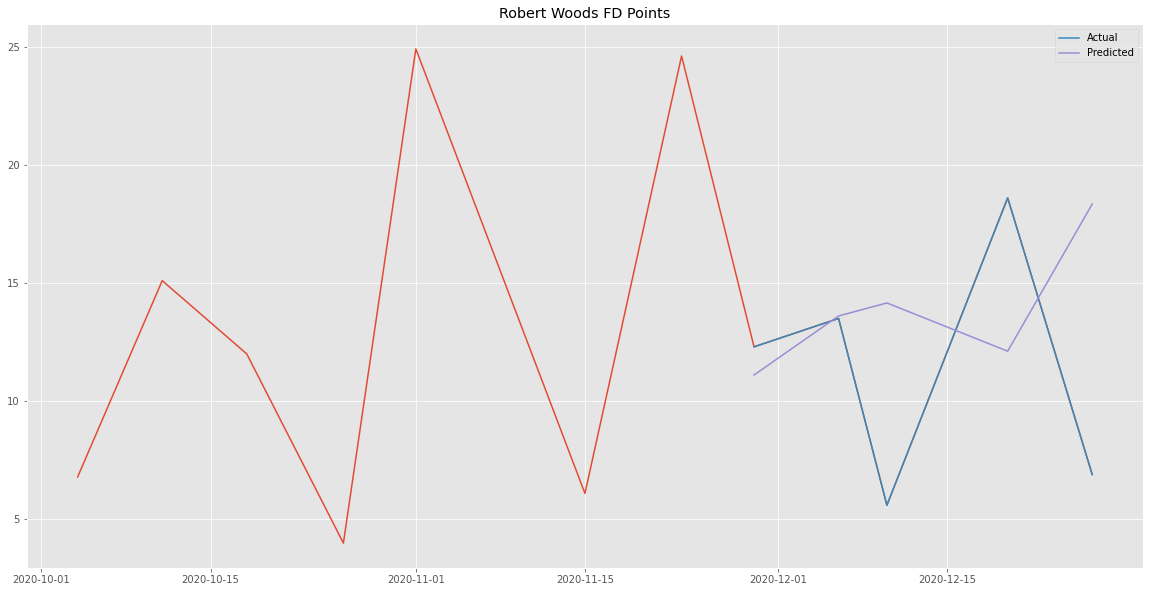

   Actual  Predicted
0    12.3  11.108456
1    13.5  13.606313
2     5.6  14.155840
3    18.6  12.115487
4     6.9  18.337536


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


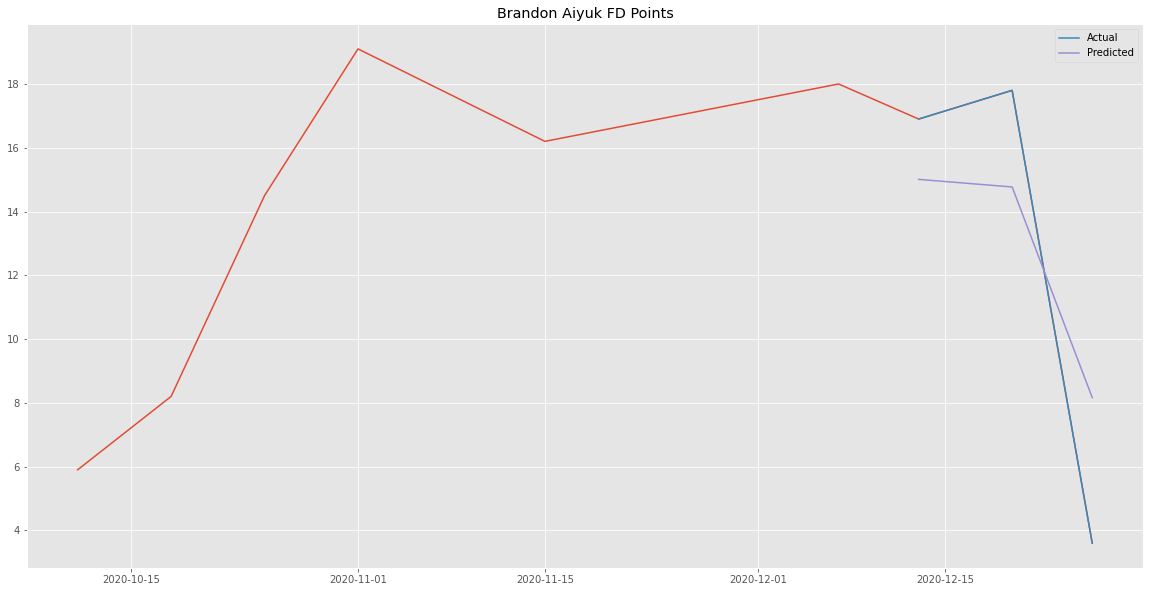

   Actual  Predicted
0    16.9  15.007342
1    17.8  14.770421
2     3.6   8.164665


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


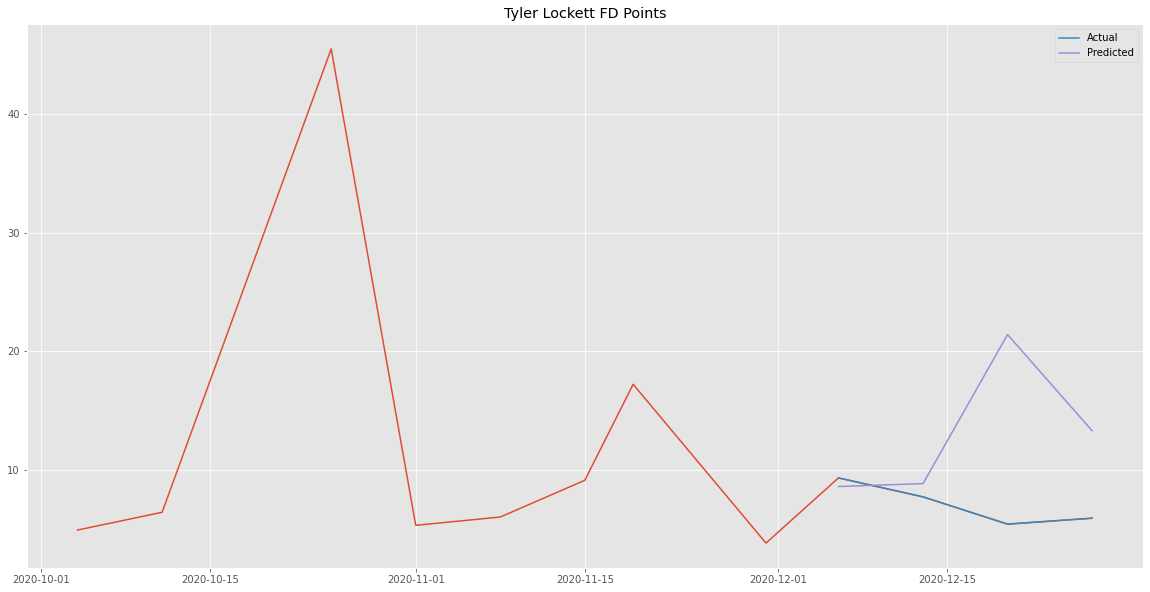

   Actual  Predicted
0     9.3   8.574502
1     7.7   8.819662
2     5.4  21.395494
3     5.9  13.280806


In [15]:
# function fo an individual player to run in the trained neural net to create a forecast
def fantasyForecast(scaler, scaler2, player_name,k):
    df = pd.read_csv('bestWrs.csv')
    
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df.dropna(inplace=True)
    df.Date = pd.to_datetime(df.Date)
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    y = df.iloc[:,4]
    x = df.iloc[:,16:]
    testDF = df.loc[int(.55*len(x)):]
    individualTrain = df[df.Name.str.contains(player_name)]
    dfIndividual = testDF[testDF.Name.str.contains(player_name)]
    dfIndividual_y = dfIndividual.iloc[:,4]
    dfIndividual_x = dfIndividual.iloc[:,16:]
    
    test_data_x = scaler.transform(np.asarray(dfIndividual_x))
    test_data_y =scaler2.transform(np.asarray(dfIndividual_y).reshape(-1,1))
    
    X_test = []
    Y_test = []
    
    # LOOP FOR TESTING DATA
    for i in range(k,test_data_x.shape[0]):
        X_test.append(test_data_x[i-k:i])
        Y_test.append(test_data_y[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    
    # PREDICTIONS
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    
    # PREDICTIONS TO DATAFRAME 
    test=pd.DataFrame()
    test=pd.DataFrame(columns=['Actual', 'Predicted'])
    test['Actual']=Y_test
    test['Predicted']=Y_hat
    table=test                   
    
    return individualTrain, dfIndividual, table, player_name


# plot the projections of the top players after removing those lacking enough data in the out of sample range
# drop Fuller, Golladay, Jones, Odell as they do not have enough data in the desired period
wrNames.remove(['Will', 'Fuller'])
wrNames.remove(['Kenny', 'Golladay'])
wrNames.remove(['Julio', 'Jones'])
wrNames.remove(['Odell', 'Beckham', 'Jr.'])

# loop for all players in wrNames to create a forecast
for x in wrNames:
    
    individualTrain, dfIndividual, modelForecast, player_name = fantasyForecast(scaler, scaler2, x[0] + ' ' + x[1],k)
    forecast(player_name,scaler2, modelForecast, dfIndividual, individualTrain, k)



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


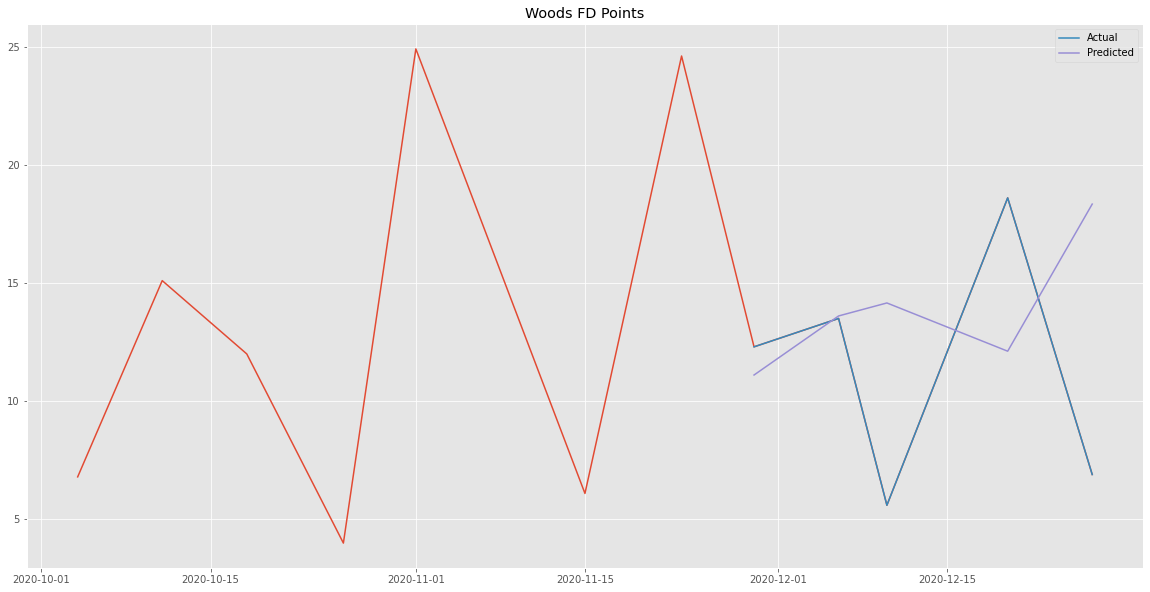

   Actual  Predicted
0    12.3  11.108456
1    13.5  13.606313
2     5.6  14.155840
3    18.6  12.115487
4     6.9  18.337536


In [16]:
# create projections for a singular player
individualTrain, dfIndividual, modelForecast, player_name = fantasyForecast(scaler, scaler2, 'Woods',k)
forecast(player_name,scaler2, modelForecast, dfIndividual, individualTrain, k)